![Forecasting Demo 1: Baselines, Prophet, and NeuralProphet](https://raw.githubusercontent.com/VectorInstitute/forecasting-bootcamp/media-assets-do-not-merge/forecasting-demo-1.png?token=GHSAT0AAAAAABQMCWQFQHUMDN4MVB2LEQDUYQ7WXUQ)

This notebook is the first of a series that introduces the application of popular, recently developed time series forecasting methods. In particular, we emphasize the use of consistent evaluation metrics and analysis across all models and model configurations. 

Use these notebooks as tools to explore the application of various forecasting methods to multivariate time series datasets, and to inspire an experimental approach for comparing multiple models and model configurations.

This notebook explores the application of **Prophet** and **NeuralProphet** to exchange rate forecasting, as well as two baseline methods using **sktime**.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install prophet
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    !pip install sktime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sktime.forecasting.naive import NaiveForecaster
from prophet import Prophet
from neuralprophet import NeuralProphet

# Data Loading

### Load exchange rate data file

The used dataset includes daily exchange rates between CAD and 12 other currencies between 2007 and 2017.

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

### Split data according to use case

For simplicity, this notebook uses a conventional training and testing split over the dataset. Other notebooks will give examples of rolling cross validation using multiple validation periods given by a set of cutoff dates. 

The purpose of this notebook is to explore a simpler problem formulation using multiple models. The experiments and analysis can be easily adapted for rolling cross validation.

In [33]:
data_filename = "/ssd003/projects/forecasting_bootcamp/bns_data/bns2_data_10k.csv"
data_df = pd.read_csv(data_filename, index_col=0)
data_df = data_df.reset_index().rename({'index':'balance_date'}, axis=1)

train_df = data_df[(data_df['balance_date'] < '2022-02-01')]
test_df = data_df[(data_df['balance_date'] > '2022-01-31') ]

train_df = train_df.drop_duplicates(subset=['acc_id', 'cust_id','transit_id','balance','balance_date'], keep='first')
test_df = test_df.drop_duplicates(subset=['acc_id', 'cust_id','transit_id','balance','balance_date'], keep='first')


train_counts = train_df.groupby(['acc_id','cust_id']).size().reset_index(name='count').sort_values(['count'], ascending=False) 
test_counts = test_df.groupby(['acc_id','cust_id']).size().reset_index(name='count').sort_values(['count'], ascending=False) 

train_filtered = train_counts[train_counts['count']>300]
train_filtered = train_filtered[['acc_id','cust_id']]
train_df2 = pd.merge(train_df, train_filtered,  how='right', left_on=['acc_id','cust_id'], right_on = ['acc_id','cust_id'])
test_df2 =  pd.merge(test_df, train_filtered,  how='right', left_on=['acc_id','cust_id'], right_on = ['acc_id','cust_id'])

print(f"Train Set Count: {train_df.shape[0]}")
print(f"Test Set Count: {test_df.shape[0]}")
print(f"Train Set Distinct Dates: {len(train_df.groupby(['balance_date']))}")
print(f"Test Set Distinct Dates: {len(test_df.groupby(['balance_date']))}")

Train Set Count: 2635246
Test Set Count: 248277
Train Set Distinct Dates: 301
Test Set Distinct Dates: 25


In [34]:
train_df = train_df[train_df.acc_id.isin([106275,106282,106283,106284,106285,106286,106287,106288,106289,106290])]
test_df = test_df[test_df.acc_id.isin([106275,106282,106283,106284,106285,106286,106287,106288,106289,106290])]

print(f"Train Set Count: {train_df.shape[0]}")
print(f"Test Set Count: {test_df.shape[0]}")
print(f"Train Set Distinct Dates: {len(train_df.groupby(['balance_date']))}")
print(f"Test Set Distinct Dates: {len(test_df.groupby(['balance_date']))}")

Train Set Count: 3010
Test Set Count: 250
Train Set Distinct Dates: 301
Test Set Distinct Dates: 25


To ensure that we have enough data for testing, we need to withhold at least `lag_time + lead_time` observations from the dataset. Assuming we want to test a fitted model on all available examples in the test set, the number of testing examples can be computed as follows.

In [35]:
lag_time = 90
lead_time = 60

n_test_cases = len(test_df) - lag_time - lead_time + 1
print(f"   Timesteps in test_df: {len(test_df)}")
print(f"Number of test examples: {n_test_cases}")

   Timesteps in test_df: 250
Number of test examples: 101


### Iterating over test examples

To help with iterating over valid pairs of input and target data, we define a PyTorch-like dataset class. In this notebook, we'll use this primarily for iterating over test examples, since both Prophet and NeuralProphet impose their own, special formats for passing in training data.

In [36]:
class ForecastingDataset:

    def __init__(self, data_df, lag_time, lead_time, feature_columns):
        self.n_examples = len(data_df) - lag_time - lead_time + 1
        assert self.n_examples > 0, "Dataset must contain at least one example."
        assert "balance_date" in data_df.columns or "ds" in data_df.columns, "Source DataFrame must contain a date/ds column."

        self.df = data_df[feature_columns]
        if 'balance_date' in data_df.columns:
            self.dates = data_df.balance_date
        elif 'ds' in data_df.columns:
            self.dates = data_df.ds
        self.lag_time = lag_time
        self.lead_time = lead_time

    def __len__(self):
        return self.n_examples

    def __getitem__(self, idx):
        input = self.df.iloc[idx:idx+lag_time]
        output = self.df.iloc[idx+lag_time:idx+lag_time+lead_time]
        input_dates = self.dates[idx:idx+lag_time]
        output_dates = self.dates[idx+lag_time:idx+lag_time+lead_time]
        return input, output, input_dates, output_dates

Next, we instantiate an indexable `test_dataset`. 

In [37]:
feature_columns = [col for col in test_df if col.endswith("balance_date")]
test_dataset = ForecastingDataset(test_df, lag_time, lead_time, feature_columns)

['balance_date']


# Prophet

Univariate forecasting that supports additional *future* regressors. Prophet does not support the inclusion of *lagged regressors*, i.e. it does not support the use of historical values of multiple series to predict a single target series. We include it as a baseline because it is popular, lightweight, interpretable, and performs very well in some domains. 

Prophet is based on a Generalized Additive Model (GAM):

$ y(t) = g(t) + s(t) + h(t) + \epsilon_t$

where $y(t)$ is the target series, $g(t)$ is the trend function, $s(t)$ is the seasonality or periodic function, $h(t)$ is a function reflecting holidays or other irregular events, and $\epsilon_t$ is an error term that is assumed to be normally distributed.

Despite being formulated as an additive model, multiplicative interaction between seasonality and trend components is supported (using a log transform). In the implementation, this is easily configurable using a constructor paramter. See the [documentation](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) for more details.

#### Data Preparation

Prophet, like most forecasting packages, imposes its own, specific format for input data. It expects inputs in the form of a Pandas DataFrame with two columns, `ds` and `y`, which correspond to Pandas-formatted timestamps and the target time series, respectively.

In this example, we create a Prophet DataFrame by selecting the columns `date` and `USD_CLOSE` from the Bank of Canada exchange rate dataset. We then rename those columns to `ds` and `y`, respectively. 

Note that the `ds` column is already correctly formatted using the Pandas datetime format, since we converted it immediately after loading the data. When reading CSVs, always be sure to check that datestamps are properly formatted.

In [45]:
prophet_model_df = train_df[['balance_date', 'balance']]
prophet_model_df = train_df.rename({'balance_date':'ds', 'balance':'y'}, axis=1)
prophet_model_df = prophet_model_df[['ds', 'y']]
prophet_model_df

,ds,y
759656,2021-05-06,577.85
759658,2021-09-20,696.15
759660,2021-09-08,696.15
759661,2022-01-12,1644.91
759662,2021-11-25,773.34
...,...,...
2734338,2021-06-15,-74.61
2734339,2021-05-11,152.33
2734341,2021-10-29,-111.27
2734342,2021-11-08,-165.02


### Model Initialization and Fitting

For our baseline model, we fit Prophet using its default configuration.

In [46]:
model = Prophet()
model = model.fit(prophet_model_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -90.5287
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       3010.11   2.15551e-07       77.2136      0.2861           1      137   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


### Produce Forecasts

To produce a forecast using a fitted Prophet model, we need to pass it a dataframe with the desired timestamps in a column named `ds`. In the example below, we use the fitted model object to produce a dataframe `future` with dates that extend `len(test_df)` days beyond the training dates. Passing `future` to the fitted model's `predict` function will return a dataframe populated with a detailed forecast, including model component values and confidence ranges.

Notice here that we are asking Prophet to produce a single forecast for the entire test period. We are doing this because Prophet does not support inference using fixed-sized inputs in the same way that every other technique considered in our bootcamp does. 

In [47]:
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

In [48]:
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
296,2022-01-26,8672.696144,-13016.497374,31125.331827,8672.696144,8672.696144,404.179430,404.179430,404.179430,404.179430,404.179430,404.179430,0.0,0.0,0.0,9076.875574
297,2022-01-27,8682.312929,-13239.552326,29746.761591,8682.312929,8682.312929,420.018747,420.018747,420.018747,420.018747,420.018747,420.018747,0.0,0.0,0.0,9102.331676
298,2022-01-28,8691.929714,-12787.207078,30423.192123,8691.929714,8691.929714,579.151863,579.151863,579.151863,579.151863,579.151863,579.151863,0.0,0.0,0.0,9271.081577
299,2022-01-29,8701.546499,-13739.683886,31271.078766,8701.546499,8701.546499,495.720310,495.720310,495.720310,495.720310,495.720310,495.720310,0.0,0.0,0.0,9197.266810
300,2022-01-31,8720.780069,-13801.327629,30498.766086,8720.780069,8720.780069,474.920577,474.920577,474.920577,474.920577,474.920577,474.920577,0.0,0.0,0.0,9195.700646


### Plotting Prophet Forecasts

The following code visualizes the application of the fitted Prophet model to both in-sample (training) and out-of-sample (testing) data. Visualization and evaluation of forecasting models using out-of-sample data is crucial for estimating future performance.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.fill_between(forecast.ds.iloc[:-len(test_df)], 
    forecast.yhat_lower.iloc[:-len(test_df)], 
    forecast.yhat_upper.iloc[:-len(test_df)],
    color='blue', label='In-Sample confidence interval (80%)', alpha=0.15)

ax.fill_between(forecast.ds.iloc[-len(test_df):], 
    forecast.yhat_lower.iloc[-len(test_df):], 
    forecast.yhat_upper.iloc[-len(test_df):],
    color='red', label='Out-of-Sample confidence interval (80%)', alpha=0.1)

ax.scatter(prophet_model_df.ds, prophet_model_df['y'], color='slategrey', s=3, linewidths=0, label='Train Samples')
ax.scatter(test_df.date, test_df['balance'], color='salmon', s=3, linewidths=0, label='Test Samples')

ax.plot(forecast.ds.iloc[:-len(test_df)], 
        forecast.yhat.iloc[:-len(test_df)], color='blue', label='In-Sample Forecast')

ax.plot(forecast.ds.iloc[-len(test_df):], forecast.yhat.iloc[-len(test_df):], 
        color='red', label='Out-of-Sample Forecast')

ax.legend(loc='upper left')
ax.grid(axis='y')
plt.show()

### Prophet Forecasts At Max Lead Time

As we did with the baseline methods, let's visualize Prophet's forecasts at maximum lead time. 

In [ ]:
# We can use our ForecastingDataset class to help with formatting Prophet's output.
forecast_eval_dataset = ForecastingDataset(forecast.iloc[-len(test_df):], lag_time, lead_time, ['yhat'])

fig, ax = plt.subplots(figsize=(9,4))

forecasts_at_max_lead = []
dates_at_max_lead = []

for i in range(len(forecast_eval_dataset)):
    x, y, x_d, y_d = forecast_eval_dataset[i]
    x_gt, y_gt, x_gt_d, y_gt_d = test_dataset[i]

    forecasts_at_max_lead.append(y.values[-1])
    dates_at_max_lead.append(y_d.values[-1])

ax.plot(dates_at_max_lead, forecasts_at_max_lead, color='red', label='forecast')
ax.plot(test_df.date, test_df['balance'], color='blue', label='ground truth')
plt.legend()
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Prophet")
plt.show()

With the help of the ForecastingDataset class defined earlier, iterate over each forecast and ground truth pair, and compute and collect multiple evaluation metrics as defined in the previous cell.

In [ ]:
def compute_error_metrics(ground_truth_dataset, forecast_dataset):
        
    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecast_dataset)):
        x, y, x_d, y_d = forecast_dataset[i]
        x_gt, y_gt, x_gt_d, y_gt_d = ground_truth_dataset[i]
        for metric_name, metric_fn in metrics.items(): 
            errors[metric_name].append(metric_fn(y_true=y_gt['balance'], y_pred=y))
    
    return errors

error_metrics = compute_error_metrics(test_dataset, forecast_eval_dataset)

In [ ]:
prophet_stats = compute_error_statistics(error_metrics, 'prophet')
prophet_stats['mean']

Let's now collect the mean evaluation metrics into a new DataFrame that we will use for comparative evalution against other models' forecasts.

Please note that the comparison is not completely fair - Prophet has to predict 672 steps into the future at once, whereas our baselines only have to predict the next 30 days.

In [ ]:
results_df = results_df.append(prophet_stats['mean'])
results_df.sort_values('mae')

# BNS Prophet

In [38]:
def runProphet(data_df):
    data_df.rename({'balance_date':'ds', 'balance':'y'}, axis=1, inplace=True)
    
    train_df = data_df[data_df['ds']<='2022-01-31']
    test_df = data_df[data_df['ds']>'2022-01-31']

    prophet_model_df = train_df[['ds', 'y']]
   
    model = Prophet()
    model = model.fit(prophet_model_df)
    
    future = model.make_future_dataframe(periods=len(test_df))
    forecast = model.predict(future)  
    
    return forecast, test_df

In [39]:
def plotChar(forecast, test_df,lag_time, lead_time):
    forecast_eval_dataset = ForecastingDataset(forecast.iloc[-len(test_df):], lag_time, lead_time, ['yhat'])

    fig, ax = plt.subplots(figsize=(9,4))

    forecasts_at_max_lead = []
    dates_at_max_lead = []

    for i in range(len(forecast_eval_dataset)):
        x, y, x_d, y_d = forecast_eval_dataset[i]
        x_gt, y_gt, x_gt_d, y_gt_d = test_dataset[i]

        forecasts_at_max_lead.append(y.values[-1])
        dates_at_max_lead.append(y_d.values[-1])

    ax.plot(dates_at_max_lead, forecasts_at_max_lead, color='red', label='forecast')
    ax.plot(test_df.ds, test_df['y'], color='blue', label='ground truth')
    plt.legend()
    plt.title(f"Forecasts at max lead time ({lead_time} samples) - Prophet")
    plt.show()

In [40]:
def loopCustomer_Prophet(data_df):
    forecast_dict = {}
    testdf_dict = {}
    
    data_df_s1 = data_df.groupby(['cust_id','acc_id']).balance_date.nunique().reset_index(name='counts')
    lag_time = 30
    lead_time = 10
    for index, row in data_df_s1.iterrows():
        
        #if index>=1: break;
        cust_id = row[0]
        acc_id = row[1]
        ds_current =  data_df.query("cust_id==@cust_id and acc_id==@acc_id") 
                
        print("\nCust_id",cust_id)
        forecast,test_df = runProphet(ds_current)
        forecast_dict[cust_id] = forecast
        testdf_dict[cust_id]=test_df
        
    return forecast_dict,testdf_dict

In [41]:
forecast_dict, testdf_dict = loopCustomer_Prophet(train_df)

WARNING - (py.warnings._showwarnmsg) - /ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Cust_id 100568
Initial log joint probability = -7.41383
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       397.038   0.000383807       76.7736   5.698e-06       0.001       84  LS failed, Hessian reset 
      99        397.11   4.35421e-07       77.0891      0.2667      0.6861      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       397.337    0.00273098        85.441   3.417e-05       0.001      268  LS failed, Hessian reset 
     199       397.492   4.00383e-05       79.6619      0.3326           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       398.578    0.00144066       82.0541      0.5171     0.05171      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     395       401.215   0.000333618       57.4475   4.706e-06       0.001      628  LS fail

WARNING - (py.warnings._showwarnmsg) - /ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Cust_id 101721
Initial log joint probability = -5.05854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       670.716    0.00211462       194.053      0.1613      0.1613      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       675.064   0.000867264       157.653   6.458e-06       0.001      217  LS failed, Hessian reset 
     199       677.557    0.00706975       86.4314           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       677.816   0.000196019       44.8885     3.5e-06       0.001      346  LS failed, Hessian reset 
     299       678.413     0.0128165       83.6423           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       678.681   0.000846117       84.3501   1.158e-05       0.001      552  LS fail

WARNING - (py.warnings._showwarnmsg) - /ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Cust_id 101974
Initial log joint probability = -7.99914
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       359.449   6.55211e-09       77.1071        0.28        0.28      122   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


WARNING - (py.warnings._showwarnmsg) - /ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Cust_id 104701
Initial log joint probability = -19.5797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       402.515   2.67875e-05       97.1977           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       402.517    1.6577e-09       89.8547     0.06042     0.06042      179   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


WARNING - (py.warnings._showwarnmsg) - /ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Cust_id 107198
Initial log joint probability = -6.3225
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        493.42    0.00174879       86.5778      0.6154      0.6154      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       493.976    0.00165629       126.106   1.334e-05       0.001      196  LS failed, Hessian reset 
     141        494.21   5.93021e-05       66.2929   7.774e-07       0.001      269  LS failed, Hessian reset 
     181       494.214   5.59217e-09       71.7551      0.2513      0.2513      325   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


WARNING - (py.warnings._showwarnmsg) - /ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Cust_id 112591
Initial log joint probability = -14.2797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       534.273    0.00477178        80.972           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       536.908     0.0017054        145.34   1.319e-05       0.001      206  LS failed, Hessian reset 
     199       538.664   3.48464e-06       79.3307      0.4921      0.4921      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       539.069   0.000106484       76.8314   1.153e-06       0.001      394  LS failed, Hessian reset 
     299       539.092   7.02353e-07       79.8665           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       539.382   3.12558e-05       78.2382    4.19e-07       0.001      561  LS fail

WARNING - (py.warnings._showwarnmsg) - /ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Cust_id 123749
Initial log joint probability = -12.1271
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       391.889   6.61696e-05       59.9554        2.74       0.274      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       391.956    0.00119512       82.1479           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       392.051    0.00107587       69.3836   1.214e-05       0.001      318  LS failed, Hessian reset 
     249       392.176   2.15374e-05       69.0192     2.8e-07       0.001      413  LS failed, Hessian reset 
     284       392.177   1.39485e-08       77.1994      0.2077           1      463   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


WARNING - (py.warnings._showwarnmsg) - /ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Cust_id 127450
Initial log joint probability = -5.70222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       546.046    0.00325892       191.013   3.886e-05       0.001      168  LS failed, Hessian reset 
      99       546.556    0.00439665       101.719           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       547.165   1.35833e-08       67.4301      0.2512      0.2512      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


WARNING - (py.warnings._showwarnmsg) - /ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Cust_id 132566
Initial log joint probability = -43.3366
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       469.219   1.89554e-05       67.5022      0.3085           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       469.223   7.37119e-09         65.86      0.1804      0.1804      208   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


WARNING - (py.warnings._showwarnmsg) - /ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Cust_id 135752
Initial log joint probability = -10.3045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       393.171     0.0222902       72.1788       0.406           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       393.344     0.0081459       131.661   0.0001129       0.001      165  LS failed, Hessian reset 
     168       394.608    0.00137855       80.9969   2.024e-05       0.001      285  LS failed, Hessian reset 
     199       394.672   3.79846e-05       59.6079           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       395.548   6.12869e-05       54.4152   8.596e-07       0.001      490  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356        395.55   1.63362e-08        59.127      0.6683      

Customer ID:  100568


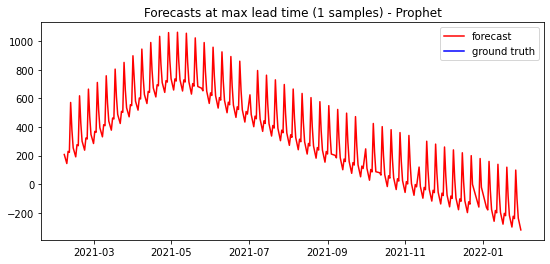

Customer ID:  101721


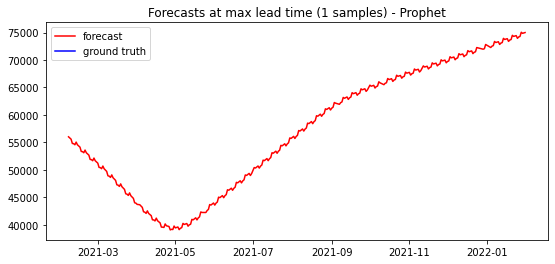

Customer ID:  101974


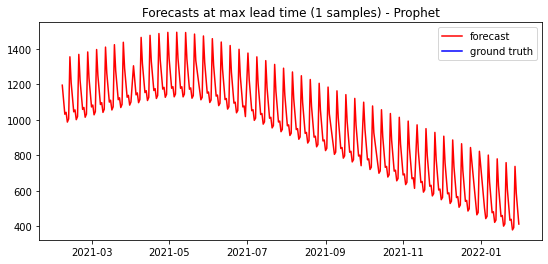

Customer ID:  104701


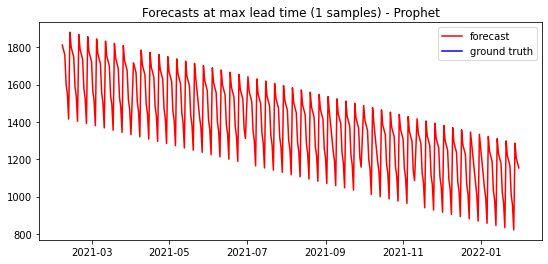

Customer ID:  107198


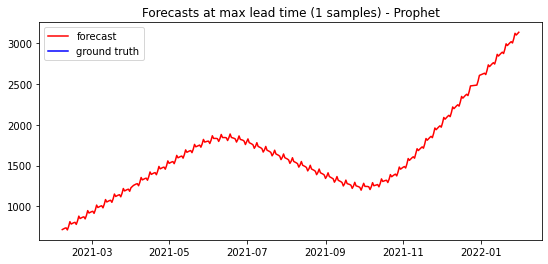

Customer ID:  112591


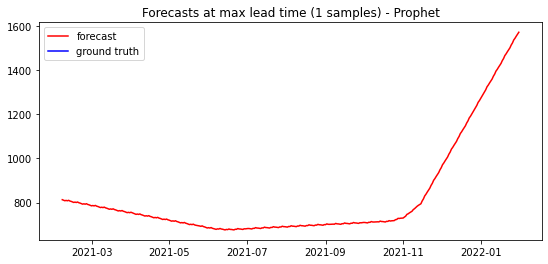

Customer ID:  123749


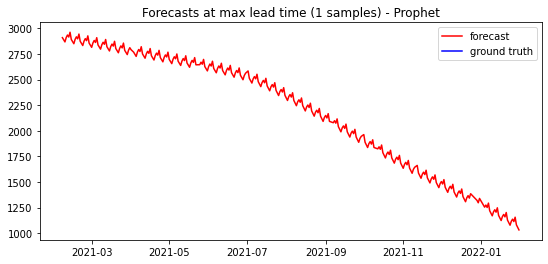

Customer ID:  127450


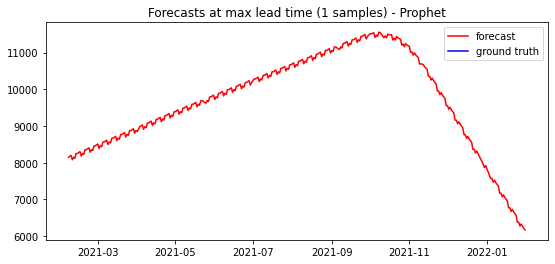

Customer ID:  132566


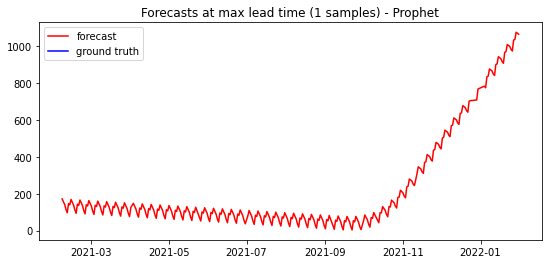

Customer ID:  135752


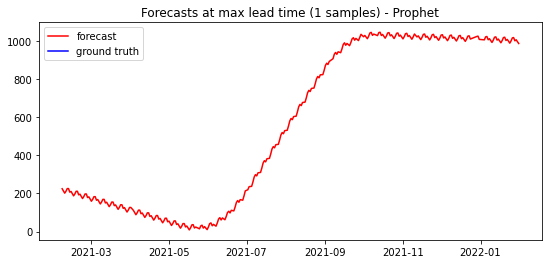

In [42]:
for cust_id in forecast_dict.keys():
    print ("Customer ID: ",cust_id)
    forecast = forecast_dict[cust_id]
    test_df = testdf_dict[cust_id]
    lag_time=5
    lead_time=1
    plotChar(forecast, test_df,lag_time, lead_time)

# NeuralProphet

Let's proceed to explore the [NeuralProphet](https://neuralprophet.com/html/index.html) model. Please review the following resources to learn more:

- [Paper](https://arxiv.org/abs/2111.15397)
- [Documentation](https://neuralprophet.com/html/contents.html)
- [GitHub](https://github.com/ourownstory/neural_prophet)

In the words of its developers, NeuralProphet is "*based on neural networks, inspired by Facebook Prophet and AR-Net, built on PyTorch*". A very important differentiating feature is that NeuralProphet conveniently supports *lagged regressors*. In the context of this running example, NeuralProphet supports the use of multiple other currencies' time series. With this expanded flexibility, however, the model is more complex, with a greater number of design choices and hyperparameters to consider. 

The official [documentation on lagged regressors (lagged covariates)](https://neuralprophet.com/html/lagged_covariates_energy_ercot.html) gives several examples for configuring NeuralProphet models to use lagged regressors, but commentary and suggestions on best practices are largely absent. 

In the following code, we will consider a small number of NeuralProphet model configurations applied to the same forecasting task from above. Importantly, we retain the same train/test (in-sample/out-of-sample) split, and we will apply the same evaluation metrics to NeuralProphet's forecasts. 

### Data Formatting

NeuralProphet's data format is very similar to Prophet's. We prepare new DataFrames for training and evaluation.

In [ ]:
np_train_df = train_df.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)
np_test_df = test_df.reset_index().rename({'date':'ds','USD_CLOSE':'y'}, axis=1).drop('index', axis=1)

Of course the most important difference between the DataFrames prepared for Prophet and NeuralProphet is that, with NeuralProphet, we have the opportunity to include data about the non-target variables as lagged regressors.

In [ ]:
np_train_df.head(5)

## Baseline/Default Model

A baseline NeuralProphet model with lagged regressors using default initialization parameters, except:

- `n_lags=lag_time`, specifying that the autoregressive component of the model should use the past `lag_time` daily observations as inputs
- `n_forecasts=lead_time`, specifying that our use case is to predict the target signal `lead_time` days into the future

NeuralProphet also allows you to specify a `validation_df` in `fit()`, on which the model will be evaluated every epoch. We are not using this feature here.

In [ ]:
np_model = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model.add_lagged_regressor(f'{feature}')
    
np_model.fit(np_train_df, freq='D')

After fitting, you can plot the learned model parameters, including the additional 30 lagged regressors.

In [ ]:
np_model.plot_parameters()

NeuralProphet, rather annoyingly, does not collect forecasts into a single yhat variable, but rather into separate `stepX`s for each of the lead times. For example, the following is a single 30-day forecast:

In [ ]:
x, y, x_d, y_d = test_dataset[0]
x = x.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)
x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
y = y.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)

np_future_df = np_model.make_future_dataframe(x, periods=len(y))
np_forecast = np_model.predict(np_future_df, decompose=False, raw=True)
np_forecast

To get a more useable data structure, the following function takes a NeuralProphet forecast dataframe and turns it into a time series of its predictions:

In [ ]:
def yhat_from_neuralprophet_forecast(np_forecast, y_d):
    return pd.Series(np_forecast.T.iloc[1:].set_index(y_d).iloc[:,0], name='np_yhat').rename_axis('ds')

The forecast from above would now look this:

In [ ]:
yhat_from_neuralprophet_forecast(np_forecast, y_d)

Since NeuralProphet uses a fixed-size input sequence (lagged observations) to produce forecasts, we iterate over the input sequences in the test set and use them as model inputs to produce forecasts. This mode of inference should be more familiar to machine learning practitioners than Prophet's. Note that NeuralProphet requires us to first format input data using the `make_future_dataframe` function before running inference using the `predict` function. We define the following function, which produces forecasts for each of the input/ground-truth-output sequences in the test set.

In [ ]:
def collect_np_forecasts(np_model, test_dataset):

    forecasts = []

    for i in range(len(test_dataset)):
        
        x, y, x_d, y_d = test_dataset[i]
        x = x.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)
        x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
        y = y.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)

        np_future_df = np_model.make_future_dataframe(x, periods=len(y))
        np_forecast = np_model.predict(np_future_df, decompose=False, raw=True)
        fc_series = yhat_from_neuralprophet_forecast(np_forecast, y_d)
        forecasts.append(fc_series)

    return forecasts

Similarly to what we defined for Prophet, we define the following function for computing and collecting evaluation metrics over all of the forecasts.

In [ ]:
def compute_np_error_metrics(forecasts):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecasts)):
        
        fc = forecasts[i]
        gt = test_df.loc[test_df.date.isin(fc.index)].sort_values('date')  # Sorting because I am not 100% sure that the 'isin' function always preserves order.
        
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=gt['USD_CLOSE'], y_pred=fc))

    return errors, forecasts

In [ ]:
forecasts = collect_np_forecasts(np_model, test_dataset)
np_baseline_error_metrics, fcs = compute_np_error_metrics(forecasts)

### Plot all forecasts

We have the option to visualize complete forecasts at every time step, but it does not tell us much about the model's performance.

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(forecasts)):

    fc = forecasts[i]
    gt = test_df.loc[test_df.date.isin(fc.index)]

    ax.plot(fc.index[:], fc[:], alpha=0.1, color='red')
    ax.plot(gt.date, gt['USD_CLOSE'], alpha=0.1, color='blue')
plt.title(f"Forecasts at all lead times (1 to {lead_time} samples)")
plt.show()

### Plot all forecasts at max lead time

In [ ]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.date, test_df['USD_CLOSE'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Persistence")
plt.legend(loc='upper right')

In [ ]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['date', 'USD_CLOSE']]
plt.plot(ground_truth.date, ground_truth['USD_CLOSE'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts[-1], label='forecast')
plt.legend()

### Append evaluation metrics to `results_df`

In [ ]:
results_df = results_df.append(compute_error_statistics(np_baseline_error_metrics, 'neural_prophet_baseline')['mean'])
results_df.sort_values('mae')

## Restricted model

The baseline NeuralProphet model does not perform well on out-of-sample data. We can consider multiple changes to the model's configuration and hyperparameters in pursuit of better performance. Let's consider the following configuration that restricts the model to using only the last observed value of last regressors, as opposed to `n_lags` past observations. While less expressive, this model may be less prone to overfitting.

In [ ]:
np_model_last_sample_only = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model_last_sample_only.add_lagged_regressor(f'{feature}', only_last_value=True)
    
np_model_last_sample_only.fit(np_train_df, freq='D')
forecasts = collect_np_forecasts(np_model_last_sample_only, test_dataset)
np_last_sample_only_error_metrics, fcs = compute_np_error_metrics(forecasts)

Once again, we are able to plot the learned parameters of the model. The lagged regressors are now grouped together in a single chart, as only one value of each is used.

In [ ]:
np_model_last_sample_only.plot_parameters()

### Plot forecasts at max lead time

In [ ]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.date, test_df['USD_CLOSE'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Persistence")
plt.legend(loc='upper right')

In [ ]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['date', 'USD_CLOSE']]
plt.plot(ground_truth.date, ground_truth['USD_CLOSE'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts[-1], label='forecast')
plt.legend()

### Append evaluation metrics to `results_df`

In [ ]:
results_df = results_df.append(compute_error_statistics(np_last_sample_only_error_metrics, 'neural_prophet_last_sample_only')['mean'])
results_df.sort_values('mae')

## Model with Sparse Neural Autoregression

In the previous parameter plots, you could see high values for all autoregressive features. You can tell NeuralProphet to try avoiding relying on them too much by restricting how many of them it is able to use. In this case, we set `ar_sparsity` to 0.1, meaning the least informative 90% of AR coefficients will not be included in the model. But: NeuralProphet applies this sparsity factor only to the regular AR coefficients, not the lagged regressor AR coefficients, where higher sparsity would make more sense.

We can also play around with parameters like the number of hidden layers or the learning rate of the AR-Net. Another change applied to this model is the loss function, now MAE instead of the default Huber loss.

In [ ]:
np_model_sparse_nar = NeuralProphet(n_lags=lag_time, 
                                    n_forecasts=lead_time,
                                    ar_sparsity=0.1,
                                    learning_rate=5e-3,
                                    num_hidden_layers=2,
                                    d_hidden=16,
                                    loss_func='MAE'
                                    )

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model_sparse_nar.add_lagged_regressor(f'{feature}')
    
np_model_sparse_nar.fit(np_train_df, freq='D')
forecasts = collect_np_forecasts(np_model_sparse_nar, test_dataset)
np_sparse_ar_error_metrics, fcs = compute_np_error_metrics(forecasts)

In [ ]:
np_model_sparse_nar.plot_parameters()

### Plot forecasts at max lead time

In [ ]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.date, test_df['USD_CLOSE'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Persistence")
plt.legend(loc='upper right')

In [ ]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['date', 'USD_CLOSE']]
plt.plot(ground_truth.date, ground_truth['USD_CLOSE'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts[-1], label='forecast')
plt.legend()

### Append evaluation metrics to `results_df`

In [ ]:
results_df = results_df.append(compute_error_statistics(np_sparse_ar_error_metrics, 'neural_prophet_sparse_ar')['mean'])
results_df.sort_values('mae')

# Reflections and Next Steps

So far, the best performing 'model' is the persistence forecasting model. This is, of course, an unsatisfactory result. The best performing experimental model on the exchange rates dataset is the restricted NeuralProphet model that uses only the last observation of lagged regressors as features. Of course, we have only considered a very small number of comfigurations using NeuralProphet, many more model and hyperparameter configurations are possible. Please refer to the [NeuralProphet documentation](https://neuralprophet.com/html/contents.html) for detailed information. However, to *find* a better configuration may require significant effort, either manual or automated (via a hyperparameter search, for example). In practical forecasting use cases, it may be important to consider the time, resources, and effort that are needed to find a forecasting model that is better than  baseline.

The following notebooks in this series will cover additional models (N-BEATS and DeepAR) as well as rolling cross validation using NeuralProphet. In order to compare the out-of-sample forecasts produced by this notebook to others, the `results_df` DataFrame is saved below. Hopefully we will find a model that performs better than baseline in a continued out-of-sample evaluation experiment!

In [ ]:
output_filename = "/h/kkoch/forecasting-bootcamp/demos/exchange_rate_mean_test_metrics.csv"
results_df.to_csv(output_filename)